# Forecasting CNBS
Lindsay Fitzpatrick
ljob@umich.edu
08/19/2024
Updated: 03/17/2025

This script performs the following tasks:

1. Loads the database containing processed CFS forecast data.
2. Passes the forecast data through the trained model(s).
3. Generates an ensemble of CNBS forecasts for each of the Great Lakes.
4. Saves the forecasts to a database and/or CSV file.
5. Creates a figure with time series plots and exports it as a PNG file.

The script requires the following files:
- cfs_forecast_data.db
- x_scaler.joblib
- y_scaler.joblib

And at least one or more of the following trained models:
- GP_trained_model.joblib
- RF_trained_model.joblib
- LR_trained_model.joblib
- NN_trained_model.joblib

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import sqlite3
import os
import sys

In [3]:
from importlib import reload
import src.hydro_utils
reload(src.hydro_utils)

<module 'src.hydro_utils' from '/Users/ljob/Desktop/cnbs-predictor/src/hydro_utils.py'>

In [2]:
# Add the path to the src directory (two levels up)
sys.path.append(os.path.abspath('../../'))
from src.data_processing import filter_predictions, predict_cnbs, format_predictions, add_df_to_db
from src.hydro_utils import convert_mm_to_cms

# User Input

In [4]:
# Directory where the repository is cloned
path_to_repo = '/Users/ljob/Desktop/'

# Path to data directory
dir = path_to_repo + 'cnbs-predictor/data/'

# Path to input CFS forecast database
cfs_database = dir + 'input/cfs_forecast_data.db'

# Path to save CNBS forecast output to a database
cnbs_database = dir + 'forecast/cnbs_forecast.db'

# Path to saved scalers
x_scaler = dir + 'input/x_scaler.joblib'
y_scaler = dir + 'input/y_scaler.joblib'

# Define directory to models to use along with their paths
models_info = [{'model': 'GP', 'path': dir + 'input/GP_trained_model.joblib'},
               {'model': 'RF', 'path': dir + 'input/RF_trained_model.joblib'},
               {'model': 'LR', 'path': dir + 'input/LR_trained_model.joblib'},
               {'model': 'NN', 'path': dir + 'input/NN_trained_model.joblib'}]

# Begin Script

In [5]:
# Create a connection to the SQLite database
conn = sqlite3.connect(cfs_database)

# Define the query to get all the data
query = '''
SELECT * FROM cfs_forecast_data
'''

# Execute the query and fetch the data into a DataFrame
data = pd.read_sql(query, conn)

# Close the connection once done
conn.close()

data.set_index(['cfs_run', 'month', 'year'], drop=True, inplace=True)

In [6]:
# This creates 1 column with a variable name that combines column names from the database
# It just makes it simplier for the moment to call the data
data['variable'] = data['lake'] + '_' + data['surface_type'] + '_' + data['cnbs']

In [7]:
# The variable names based on the above step in the order that they need to be in based on the order of variables during the training step
variables = ['superior_lake_precipitation', 'erie_lake_precipitation', 'ontario_lake_precipitation', 
             'michigan-huron_lake_precipitation', 'superior_land_precipitation', 'erie_land_precipitation',
             'ontario_land_precipitation', 'michigan-huron_land_precipitation', 'superior_lake_evaporation',
             'erie_lake_evaporation', 'ontario_lake_evaporation', 'michigan-huron_lake_evaporation',
             'superior_land_evaporation', 'erie_land_evaporation', 'ontario_land_evaporation',
             'michigan-huron_land_evaporation', 'superior_lake_air_temperature', 'erie_lake_air_temperature',
             'ontario_lake_air_temperature', 'michigan-huron_lake_air_temperature', 'superior_land_air_temperature',
             'erie_land_air_temperature', 'ontario_land_air_temperature', 'michigan-huron_land_air_temperature'
             ]

# Use a loop to create the DataFrame
X = pd.DataFrame({
    var: data.loc[data['variable'] == var, 'value'] for var in variables
})

# For any reason, in a worse case scenario and there are NaNs (which there would never ever be missing data), drop the rows that include them
# Check first to see if there are NaN values in the DataFrame
if X.isna().any().any():
    # Remove rows with NaN values
    print("NANs were found in the input dataset. Removing them before continuing.")
    X = X.dropna(how='any')

In [8]:
# This removes any old cfs forecasts that we do not need cnbs forecasts for (such as forecasts for months that have passed). 
X_filtered = filter_predictions(X)

First month forecast: 4


In [9]:
# Initialize an empty dictionary to store predictions by model name
model_predictions = {}

# Process each model and add to DB
for model_info in models_info:
    model_name = model_info['model']
    df_y = predict_cnbs(X_filtered, x_scaler, y_scaler, models_info, model_name)
    if df_y is not None:
        # Store the predictions in the dictionary with the model name as the key
        model_predictions[model_name] = df_y
        
        df_y_formatted = format_predictions(df_y.reset_index(), model_name)

        # Remove any unwanted rows where 'lake' or 'cnbs' have undesirable values like 'index' or 'None'
        df_y_formatted = df_y_formatted[df_y_formatted['lake'] != 'index']
        df_y_formatted = df_y_formatted[df_y_formatted['cnbs'].notna()]

        add_df_to_db(cnbs_database, 'cnbs_forecast', df_y_formatted)

        # Calculate median values for each model for each month
        # Group by 'year', 'month', 'lake', and 'cnbs' and calculate median only on the 'value' column
        df_median = df_y_formatted.groupby(['year', 'month', 'lake', 'cnbs'])['value'].median().round(3).reset_index()
        
        # Add a new column 'model_name' with the value "GP"
        df_median['model_name'] = model_name

        # Reorder columns to place 'model_name' between 'month' and 'lake'
        df_median_mm = df_median.sort_values(by=['month', 'year', 'model_name', 'lake', 'value']).set_index(['month', 'year'])

        add_df_to_db(cnbs_database, 'cnbs_forecast_median', df_median_mm)
        print(f"Added forecast values using {model_name} to database {cnbs_database}.")

Added forecast values using GP to database /Users/ljob/Desktop/cnbs-predictor/data/forecast/cnbs_forecast.db.
Added forecast values using RF to database /Users/ljob/Desktop/cnbs-predictor/data/forecast/cnbs_forecast.db.
Added forecast values using LR to database /Users/ljob/Desktop/cnbs-predictor/data/forecast/cnbs_forecast.db.
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
Added forecast values using NN to database /Users/ljob/Desktop/cnbs-predictor/data/forecast/cnbs_forecast.db.


In [10]:
# Calculate the median forecast value for each month from the entire ensemble
combined_dataset = pd.concat(model_predictions)
df_median_mm = combined_dataset.groupby(['year', 'month']).median().round(3) # Rounds to 3 decimal places

Forecasts can be saved to a CSV in either [mm] or [cms] is the user desires.

In [11]:
# Save to a CSV [mm]
df_median_mm.to_csv(f'{dir}forecast/CNBS_forecast_mm.csv', sep='\t', index=True)

# Convert mm to cms
df_cms = convert_mm_to_cms(df_median_mm).round(3)

# Save to a CSV [cms]
df_cms.to_csv(f'{dir}forecast/CNBS_forecast_cms.csv', sep='\t', index=True)

In [12]:
median_predictions = {}
for model_name, df in model_predictions.items():
    median_predictions[model_name] = df.groupby(['year', 'month']).median().round(3)

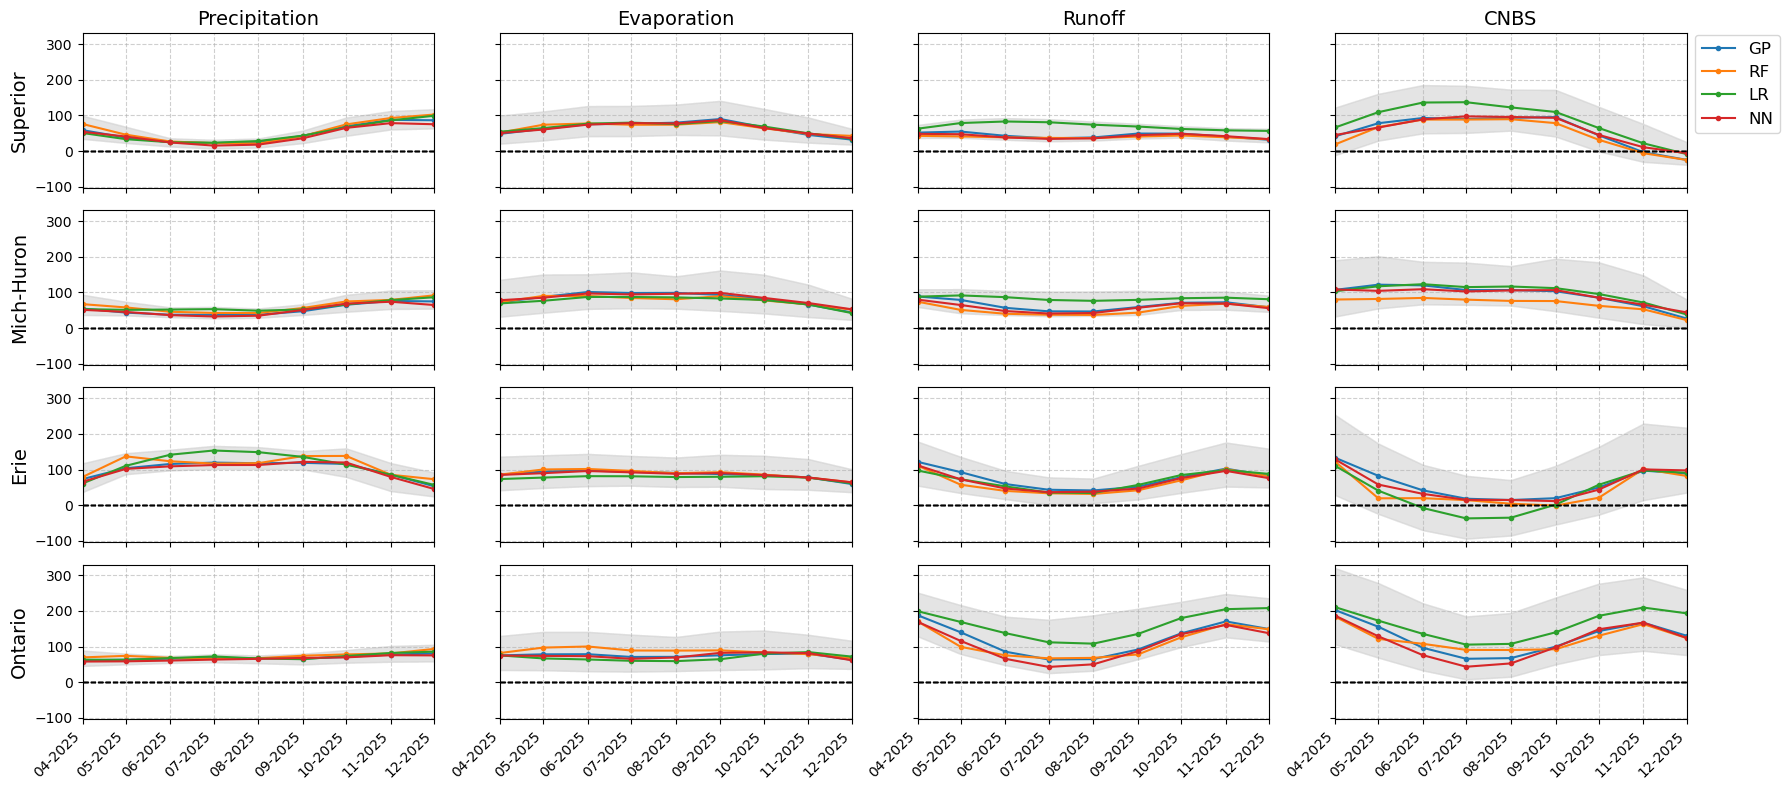

In [13]:
# Columns of interest in the order we want to plot them
columns = ['superior_evaporation', 'superior_precipitation', 'superior_runoff', 'superior_cnbs',
           'michigan-huron_evaporation', 'michigan-huron_precipitation', 'michigan-huron_runoff', 'michigan-huron_cnbs',
           'erie_evaporation', 'erie_precipitation', 'erie_runoff', 'erie_cnbs',
           'ontario_evaporation', 'ontario_precipitation', 'ontario_runoff', 'ontario_cnbs']

# Create a 1x4 subplot grid
fig, axs = plt.subplots(4, 4, figsize=(18, 8))

global_y_min, global_y_max = float('inf'), float('-inf')  # Initialize to extremes. This will update in the loop 

# Loop over the columns and plot the medians for each dataset
for i, column in enumerate(columns):
    row = i // 4  # Row index (integer division by 4)
    col = i % 4   # Column index (remainder after division by 4)

    lower_bound = combined_dataset.groupby(['year', 'month'])[column].quantile(0.025).reset_index()
    upper_bound = combined_dataset.groupby(['year', 'month'])[column].quantile(0.975).reset_index()

    for model_name, df in model_predictions.items():
        # Get the grouped DataFrame for the current model
        median_df = df.groupby(['year', 'month']).median().round(3)

        # Add a 'date' column to the median DataFrame
        median_df = median_df.reset_index()
        median_df['date'] = pd.to_datetime(median_df[['year', 'month']].assign(day=1))

        # Plot the medians for the current dataset on the same subplot
        axs[row, col].plot(median_df['date'], median_df[column], marker='o', markersize=3, label=model_name)

        # Add the shaded region (confidence band)
        axs[row, col].fill_between(median_df['date'], lower_bound[column], upper_bound[column], color='lightgray', alpha=0.2)
        axs[row, col].axhline(0, color='black', linestyle='--', linewidth=1) # Add a dashed line on 0
        axs[row, col].grid(True, linestyle='--', alpha=0.6) # Turn on a grid
        axs[row, col].set_yticks(np.arange(-1000, 1000, 100)) # Force y ticks on every 100

        # Update the global y-axis limits based on the current dataset
        # This allows us to set a y min and y max that is the same for all of the figures at the end
        current_y_min = lower_bound[column].min()
        current_y_max = upper_bound[column].max()
        global_y_min = min(global_y_min, current_y_min)
        global_y_max = max(global_y_max, current_y_max)

    # Set titles based on row and column
    if row == 0:
        axs[row, col].set_title(['Precipitation', 'Evaporation', 'Runoff', 'CNBS'][col], fontsize=14)
    else:
        axs[row, col].set_title('')

    # Format x-axis for the last row (set x-tick labels)
    if row == 3:
        axs[row, col].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%Y')) # Format the dates on the x axis
        axs[row, col].tick_params(axis='x', rotation=45)  # Rotate the x-axis labels for better readability
        for label in axs[row, col].get_xticklabels(): # Position the labels
            label.set_horizontalalignment('right')
    else:
        axs[row, col].set_xticklabels([]) # Turn off x axis labels on all of the plots but the bottom row

    # Set y-axis labels for the first column only
    if col == 0:
        axs[row, col].set_ylabel(['Superior', 'Mich-Huron', 'Erie', 'Ontario'][row], fontsize=14)
    else:
        axs[row, col].set_yticklabels([]) # Turn off titles 

# Set consistent y-axis limits across all subplots
for row in range(4):
    for col in range(4):
        axs[row, col].set_ylim(global_y_min - 10, global_y_max + 10)
        axs[row, col].set_xlim(median_df['date'].iloc[0], median_df['date'].iloc[-1])

# Position the legend outside the plot area to the right
axs[0, 3].legend(loc='lower left', bbox_to_anchor=(1, 0.3),fontsize=12)

# Save the figure as a PNG file
plt.savefig(f'{dir}forecast/CNBS_forecasts.png')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

# Define the colors for each model
model_colors = {
    'GP': 'blue',
    'RF': 'green',
    'LR': 'red',
    'NN': 'purple'
}

# Columns of interest in the order we want to plot them
columns = ['superior_evaporation', 'superior_precipitation', 'superior_runoff', 'superior_cnbs',
           'michigan-huron_evaporation', 'michigan-huron_precipitation', 'michigan-huron_runoff', 'michigan-huron_cnbs',
           'erie_evaporation', 'erie_precipitation', 'erie_runoff', 'erie_cnbs',
           'ontario_evaporation', 'ontario_precipitation', 'ontario_runoff', 'ontario_cnbs']

# Create a 1x4 subplot grid
fig = make_subplots(rows=4, cols=4, 
                    subplot_titles=['Precipitation', 'Evaporation', 'Runoff', 'CNBS'], 
                    shared_xaxes=True, shared_yaxes=True, vertical_spacing=0.05, horizontal_spacing=0.008)

global_y_min, global_y_max = float('inf'), float('-inf')  # Initialize to extremes

# Loop over the columns and plot the medians for each dataset
for i, column in enumerate(columns):
    row = i // 4  # Row index
    col = i % 4   # Column index

    lower_bound = combined_dataset.groupby(['year', 'month'])[column].quantile(0.025).reset_index()
    upper_bound = combined_dataset.groupby(['year', 'month'])[column].quantile(0.975).reset_index()

    for model_name, df in model_predictions.items():
        # Get the grouped DataFrame for the current model
        median_df = df.groupby(['year', 'month']).median().round(3)

        # Add a 'date' column to the median DataFrame
        median_df = median_df.reset_index()
        median_df['date'] = pd.to_datetime(median_df[['year', 'month']].assign(day=1))

        # Add the median line for the current model to the figure
        fig.add_trace(go.Scatter(x=median_df['date'], y=median_df[column],
                                 mode='lines+markers', name=model_name, 
                                 line=dict(shape='linear', width=2, color=model_colors[model_name]), 
                                 marker=dict(size=3), 
                                 showlegend=(row == 0 and col == 0),  # Only show legend for the first subplot
                                 hovertemplate='Date: %{x}<br>Value: %{y}<br>Model: ' + model_name),
                      row=row+1, col=col+1)

        # Add the shaded region (confidence band)
        fig.add_trace(go.Scatter(x=pd.concat([median_df['date'], median_df['date'][::-1]]),
                         y=pd.concat([lower_bound[column], upper_bound[column][::-1]]),
                         fill='toself', fillcolor='rgba(169, 169, 169, 0.2)',
                         line=dict(color='rgba(255,255,255,0)'), showlegend=False, 
                         hovertemplate='Date: %{x}<br>Conf: 95%'), 
              row=row+1, col=col+1)

        # Update global y-axis limits
        current_y_min = lower_bound[column].min()
        current_y_max = upper_bound[column].max()
        global_y_min = min(global_y_min, current_y_min)
        global_y_max = max(global_y_max, current_y_max)

    # Set x-axis range (limits) for each subplot
    #fig.update_xaxes(range=[median_df['date'].iloc[0], median_df['date'].iloc[-1]], row=row+1, col=col+1)

    # Format x-axis for the last row (set x-tick labels)
    if row == 3:
        fig.update_xaxes(tickformat='%m-%Y', tickangle=-45, row=row+1, col=col+1, tickmode='array', tickvals=median_df['date'])
    else:
        fig.update_xaxes(showticklabels=False, row=row+1, col=col+1, tickmode='array', tickvals=median_df['date'])

    # Set y-axis labels for the first column only
    if col == 0:
        fig.update_yaxes(title_text=['Superior', 'Mich-Huron', 'Erie', 'Ontario'][row], row=row+1, col=col+1)

    # Add the y=0 dashed line to every subplot
    fig.add_trace(go.Scatter(x=[median_df['date'].min(), median_df['date'].max()],
                             y=[0, 0], mode='lines', line=dict(color='black'), 
                             showlegend=False), row=row+1, col=col+1)

    # Add a box around each subplot
    #fig.update_xaxes(showline=True, linewidth=2, linecolor='black', row=row+1, col=col+1)
    #fig.update_yaxes(showline=True, linewidth=2, linecolor='black', row=row+1, col=col+1)
    
# Set consistent y-axis limits across all subplots
for row in range(1, 5):
    for col in range(1, 5):
        fig.update_yaxes(range=[global_y_min - 10, global_y_max + 10], row=row, col=col)

# Set grid lines for all subplots
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='LightGray')
fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='LightGray')

# Update layout and titles
fig.update_layout(
    title_text="9-month Great Lakes CNBS Forecasts",
    title_x=0.5,
    height=800, width=1500,
    showlegend=True,
    legend=dict(x=1.05, y=0.9, traceorder='normal', orientation='v', title='Model'),  # Move legend up
    plot_bgcolor='white',
)

# Save the figure as an interactive HTML file
fig.write_html(f'{dir}forecast/CNBS_forecasts_interactive.html')

# Show the plot (optional)
fig.show()



In [101]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

# Define the colors for each model
model_colors = {
    'GP': 'blue',
    'RF': 'green',
    'LR': 'red',
    'NN': 'purple'
}

# Columns of interest in the order we want to plot them
columns = ['superior_evaporation', 'superior_precipitation', 'superior_runoff', 'superior_cnbs',
           'michigan-huron_evaporation', 'michigan-huron_precipitation', 'michigan-huron_runoff', 'michigan-huron_cnbs',
           'erie_evaporation', 'erie_precipitation', 'erie_runoff', 'erie_cnbs',
           'ontario_evaporation', 'ontario_precipitation', 'ontario_runoff', 'ontario_cnbs']

# Create a 1x4 subplot grid
fig = make_subplots(rows=4, cols=4, 
                    subplot_titles=['Precipitation', 'Evaporation', 'Runoff', 'CNBS'], 
                    shared_xaxes=True, shared_yaxes=True, vertical_spacing=0.05, horizontal_spacing=0.008)

global_y_min, global_y_max = float('inf'), float('-inf')  # Initialize to extremes

# Loop over the columns and plot the medians for each dataset
for i, column in enumerate(columns):
    row = i // 4  # Row index
    col = i % 4   # Column index

    lower_bound = combined_dataset.groupby(['year', 'month'])[column].quantile(0.025).reset_index()
    upper_bound = combined_dataset.groupby(['year', 'month'])[column].quantile(0.975).reset_index()

    for model_name, df in model_predictions.items():
        # Get the grouped DataFrame for the current model
        median_df = df.groupby(['year', 'month']).median().round(3)

        # Add a 'date' column to the median DataFrame
        median_df = median_df.reset_index()
        median_df['date'] = pd.to_datetime(median_df[['year', 'month']].assign(day=1))

        # Add the median line for the current model to the figure
        fig.add_trace(go.Scatter(x=median_df['date'], y=median_df[column],
                                 mode='lines+markers', name=model_name, 
                                 line=dict(shape='linear', width=2, color=model_colors[model_name]), 
                                 marker=dict(size=3), 
                                 showlegend=(row == 0 and col == 0),  # Only show legend for the first subplot
                                 hovertemplate='Date: %{x}<br>Value: %{y}<br>Model: ' + model_name),
                      row=row+1, col=col+1)

        # Add the shaded region (confidence band)
        fig.add_trace(go.Scatter(x=pd.concat([median_df['date'], median_df['date'][::-1]]),
                         y=pd.concat([lower_bound[column], upper_bound[column][::-1]]),
                         fill='toself', fillcolor='rgba(169, 169, 169, 0.2)',
                         line=dict(color='rgba(255,255,255,0)'), showlegend=False, 
                         hovertemplate='Date: %{x}<br>Conf: 2.5%'), 
              row=row+1, col=col+1)

        # Update global y-axis limits
        current_y_min = lower_bound[column].min()
        current_y_max = upper_bound[column].max()
        global_y_min = min(global_y_min, current_y_min)
        global_y_max = max(global_y_max, current_y_max)

    # Set x-axis range (limits) for each subplot
    #fig.update_xaxes(range=[median_df['date'].iloc[0], median_df['date'].iloc[-1]], row=row+1, col=col+1)

    # Format x-axis for the last row (set x-tick labels)
    if row == 3:
        fig.update_xaxes(tickformat='%m-%Y', tickangle=-45, row=row+1, col=col+1, tickmode='array', tickvals=median_df['date'])
    else:
        fig.update_xaxes(showticklabels=False, row=row+1, col=col+1, tickmode='array', tickvals=median_df['date'])

    # Set y-axis labels for the first column only
    if col == 0:
        fig.update_yaxes(title_text=['Superior', 'Mich-Huron', 'Erie', 'Ontario'][row], row=row+1, col=col+1)

    # Add the y=0 dashed line to every subplot
    fig.add_trace(go.Scatter(x=[median_df['date'].min(), median_df['date'].max()],
                             y=[0, 0], mode='lines', line=dict(color='black'), 
                             showlegend=False), row=row+1, col=col+1)

    # Manually add lines around the top, right, bottom, and left edges of each subplot
    # Top line (horizontal)
    fig.add_annotation(
        x=median_df['date'].max(), 
        y=global_y_max + 10, 
        xref="x1", 
        yref="y1", 
        ax=median_df['date'].min(), 
        ay=global_y_max + 10, 
        axref="x1", 
        ayref="y1",
        line=dict(color='black', width=2)
    )
    
    # Right line (vertical)
    fig.add_annotation(
        x=median_df['date'].max(), 
        y=global_y_max + 10, 
        xref="x1", 
        yref="y1", 
        ax=median_df['date'].max(), 
        ay=global_y_min - 10, 
        axref="x1", 
        ayref="y1",
        line=dict(color='black', width=2)
    )

    # Bottom line (horizontal)
    fig.add_annotation(
        x=median_df['date'].max(), 
        y=global_y_min - 10, 
        xref="x1", 
        yref="y1", 
        ax=median_df['date'].min(), 
        ay=global_y_min - 10, 
        axref="x1", 
        ayref="y1",
        line=dict(color='black', width=2)
    )

    # Left line (vertical)
    fig.add_annotation(
        x=median_df['date'].min(), 
        y=global_y_max + 10, 
        xref="x1", 
        yref="y1", 
        ax=median_df['date'].min(), 
        ay=global_y_min - 10, 
        axref="x1", 
        ayref="y1",
        line=dict(color='black', width=2)
    )

# Set consistent y-axis limits across all subplots
for row in range(1, 5):
    for col in range(1, 5):
        fig.update_yaxes(range=[global_y_min - 10, global_y_max + 10], row=row, col=col)

# Set grid lines for all subplots
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='LightGray')
fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='LightGray')

# Update layout and titles
fig.update_layout(
    title_text="9-month Great Lakes CNBS Forecasts",
    title_x=0.5,
    height=800, width=1500,
    showlegend=True,
    legend=dict(x=1.05, y=0.9, traceorder='normal', orientation='v', title='Model'),  # Move legend up
    plot_bgcolor='white',
)

# Save the figure as an interactive HTML file
fig.write_html(f'{dir}forecast/CNBS_forecasts_interactive.html')

# Show the plot (optional)
fig.show()


ValueError: Invalid property specified for object of type plotly.graph_objs.layout.Annotation: 'line'

Did you mean "align"?

    Valid properties:
        align
            Sets the horizontal alignment of the `text` within the
            box. Has an effect only if `text` spans two or more
            lines (i.e. `text` contains one or more <br> HTML tags)
            or if an explicit width is set to override the text
            width.
        arrowcolor
            Sets the color of the annotation arrow.
        arrowhead
            Sets the end annotation arrow head style.
        arrowside
            Sets the annotation arrow head position.
        arrowsize
            Sets the size of the end annotation arrow head,
            relative to `arrowwidth`. A value of 1 (default) gives
            a head about 3x as wide as the line.
        arrowwidth
            Sets the width (in px) of annotation arrow line.
        ax
            Sets the x component of the arrow tail about the arrow
            head. If `axref` is `pixel`, a positive (negative)
            component corresponds to an arrow pointing from right
            to left (left to right). If `axref` is not `pixel` and
            is exactly the same as `xref`, this is an absolute
            value on that axis, like `x`, specified in the same
            coordinates as `xref`.
        axref
            Indicates in what coordinates the tail of the
            annotation (ax,ay) is specified. If set to a x axis id
            (e.g. "x" or "x2"), the `x` position refers to a x
            coordinate. If set to "paper", the `x` position refers
            to the distance from the left of the plotting area in
            normalized coordinates where 0 (1) corresponds to the
            left (right). If set to a x axis ID followed by
            "domain" (separated by a space), the position behaves
            like for "paper", but refers to the distance in
            fractions of the domain length from the left of the
            domain of that axis: e.g., *x2 domain* refers to the
            domain of the second x  axis and a x position of 0.5
            refers to the point between the left and the right of
            the domain of the second x axis. In order for absolute
            positioning of the arrow to work, "axref" must be
            exactly the same as "xref", otherwise "axref" will
            revert to "pixel" (explained next). For relative
            positioning, "axref" can be set to "pixel", in which
            case the "ax" value is specified in pixels relative to
            "x". Absolute positioning is useful for trendline
            annotations which should continue to indicate the
            correct trend when zoomed. Relative positioning is
            useful for specifying the text offset for an annotated
            point.
        ay
            Sets the y component of the arrow tail about the arrow
            head. If `ayref` is `pixel`, a positive (negative)
            component corresponds to an arrow pointing from bottom
            to top (top to bottom). If `ayref` is not `pixel` and
            is exactly the same as `yref`, this is an absolute
            value on that axis, like `y`, specified in the same
            coordinates as `yref`.
        ayref
            Indicates in what coordinates the tail of the
            annotation (ax,ay) is specified. If set to a y axis id
            (e.g. "y" or "y2"), the `y` position refers to a y
            coordinate. If set to "paper", the `y` position refers
            to the distance from the bottom of the plotting area in
            normalized coordinates where 0 (1) corresponds to the
            bottom (top). If set to a y axis ID followed by
            "domain" (separated by a space), the position behaves
            like for "paper", but refers to the distance in
            fractions of the domain length from the bottom of the
            domain of that axis: e.g., *y2 domain* refers to the
            domain of the second y  axis and a y position of 0.5
            refers to the point between the bottom and the top of
            the domain of the second y axis. In order for absolute
            positioning of the arrow to work, "ayref" must be
            exactly the same as "yref", otherwise "ayref" will
            revert to "pixel" (explained next). For relative
            positioning, "ayref" can be set to "pixel", in which
            case the "ay" value is specified in pixels relative to
            "y". Absolute positioning is useful for trendline
            annotations which should continue to indicate the
            correct trend when zoomed. Relative positioning is
            useful for specifying the text offset for an annotated
            point.
        bgcolor
            Sets the background color of the annotation.
        bordercolor
            Sets the color of the border enclosing the annotation
            `text`.
        borderpad
            Sets the padding (in px) between the `text` and the
            enclosing border.
        borderwidth
            Sets the width (in px) of the border enclosing the
            annotation `text`.
        captureevents
            Determines whether the annotation text box captures
            mouse move and click events, or allows those events to
            pass through to data points in the plot that may be
            behind the annotation. By default `captureevents` is
            False unless `hovertext` is provided. If you use the
            event `plotly_clickannotation` without `hovertext` you
            must explicitly enable `captureevents`.
        clicktoshow
            Makes this annotation respond to clicks on the plot. If
            you click a data point that exactly matches the `x` and
            `y` values of this annotation, and it is hidden
            (visible: false), it will appear. In "onoff" mode, you
            must click the same point again to make it disappear,
            so if you click multiple points, you can show multiple
            annotations. In "onout" mode, a click anywhere else in
            the plot (on another data point or not) will hide this
            annotation. If you need to show/hide this annotation in
            response to different `x` or `y` values, you can set
            `xclick` and/or `yclick`. This is useful for example to
            label the side of a bar. To label markers though,
            `standoff` is preferred over `xclick` and `yclick`.
        font
            Sets the annotation text font.
        height
            Sets an explicit height for the text box. null
            (default) lets the text set the box height. Taller text
            will be clipped.
        hoverlabel
            :class:`plotly.graph_objects.layout.annotation.Hoverlab
            el` instance or dict with compatible properties
        hovertext
            Sets text to appear when hovering over this annotation.
            If omitted or blank, no hover label will appear.
        name
            When used in a template, named items are created in the
            output figure in addition to any items the figure
            already has in this array. You can modify these items
            in the output figure by making your own item with
            `templateitemname` matching this `name` alongside your
            modifications (including `visible: false` or `enabled:
            false` to hide it). Has no effect outside of a
            template.
        opacity
            Sets the opacity of the annotation (text + arrow).
        showarrow
            Determines whether or not the annotation is drawn with
            an arrow. If True, `text` is placed near the arrow's
            tail. If False, `text` lines up with the `x` and `y`
            provided.
        standoff
            Sets a distance, in pixels, to move the end arrowhead
            away from the position it is pointing at, for example
            to point at the edge of a marker independent of zoom.
            Note that this shortens the arrow from the `ax` / `ay`
            vector, in contrast to `xshift` / `yshift` which moves
            everything by this amount.
        startarrowhead
            Sets the start annotation arrow head style.
        startarrowsize
            Sets the size of the start annotation arrow head,
            relative to `arrowwidth`. A value of 1 (default) gives
            a head about 3x as wide as the line.
        startstandoff
            Sets a distance, in pixels, to move the start arrowhead
            away from the position it is pointing at, for example
            to point at the edge of a marker independent of zoom.
            Note that this shortens the arrow from the `ax` / `ay`
            vector, in contrast to `xshift` / `yshift` which moves
            everything by this amount.
        templateitemname
            Used to refer to a named item in this array in the
            template. Named items from the template will be created
            even without a matching item in the input figure, but
            you can modify one by making an item with
            `templateitemname` matching its `name`, alongside your
            modifications (including `visible: false` or `enabled:
            false` to hide it). If there is no template or no
            matching item, this item will be hidden unless you
            explicitly show it with `visible: true`.
        text
            Sets the text associated with this annotation. Plotly
            uses a subset of HTML tags to do things like newline
            (<br>), bold (<b></b>), italics (<i></i>), hyperlinks
            (<a href='...'></a>). Tags <em>, <sup>, <sub>, <s>, <u>
            <span> are also supported.
        textangle
            Sets the angle at which the `text` is drawn with
            respect to the horizontal.
        valign
            Sets the vertical alignment of the `text` within the
            box. Has an effect only if an explicit height is set to
            override the text height.
        visible
            Determines whether or not this annotation is visible.
        width
            Sets an explicit width for the text box. null (default)
            lets the text set the box width. Wider text will be
            clipped. There is no automatic wrapping; use <br> to
            start a new line.
        x
            Sets the annotation's x position. If the axis `type` is
            "log", then you must take the log of your desired
            range. If the axis `type` is "date", it should be date
            strings, like date data, though Date objects and unix
            milliseconds will be accepted and converted to strings.
            If the axis `type` is "category", it should be numbers,
            using the scale where each category is assigned a
            serial number from zero in the order it appears.
        xanchor
            Sets the text box's horizontal position anchor This
            anchor binds the `x` position to the "left", "center"
            or "right" of the annotation. For example, if `x` is
            set to 1, `xref` to "paper" and `xanchor` to "right"
            then the right-most portion of the annotation lines up
            with the right-most edge of the plotting area. If
            "auto", the anchor is equivalent to "center" for data-
            referenced annotations or if there is an arrow, whereas
            for paper-referenced with no arrow, the anchor picked
            corresponds to the closest side.
        xclick
            Toggle this annotation when clicking a data point whose
            `x` value is `xclick` rather than the annotation's `x`
            value.
        xref
            Sets the annotation's x coordinate axis. If set to a x
            axis id (e.g. "x" or "x2"), the `x` position refers to
            a x coordinate. If set to "paper", the `x` position
            refers to the distance from the left of the plotting
            area in normalized coordinates where 0 (1) corresponds
            to the left (right). If set to a x axis ID followed by
            "domain" (separated by a space), the position behaves
            like for "paper", but refers to the distance in
            fractions of the domain length from the left of the
            domain of that axis: e.g., *x2 domain* refers to the
            domain of the second x  axis and a x position of 0.5
            refers to the point between the left and the right of
            the domain of the second x axis.
        xshift
            Shifts the position of the whole annotation and arrow
            to the right (positive) or left (negative) by this many
            pixels.
        y
            Sets the annotation's y position. If the axis `type` is
            "log", then you must take the log of your desired
            range. If the axis `type` is "date", it should be date
            strings, like date data, though Date objects and unix
            milliseconds will be accepted and converted to strings.
            If the axis `type` is "category", it should be numbers,
            using the scale where each category is assigned a
            serial number from zero in the order it appears.
        yanchor
            Sets the text box's vertical position anchor This
            anchor binds the `y` position to the "top", "middle" or
            "bottom" of the annotation. For example, if `y` is set
            to 1, `yref` to "paper" and `yanchor` to "top" then the
            top-most portion of the annotation lines up with the
            top-most edge of the plotting area. If "auto", the
            anchor is equivalent to "middle" for data-referenced
            annotations or if there is an arrow, whereas for paper-
            referenced with no arrow, the anchor picked corresponds
            to the closest side.
        yclick
            Toggle this annotation when clicking a data point whose
            `y` value is `yclick` rather than the annotation's `y`
            value.
        yref
            Sets the annotation's y coordinate axis. If set to a y
            axis id (e.g. "y" or "y2"), the `y` position refers to
            a y coordinate. If set to "paper", the `y` position
            refers to the distance from the bottom of the plotting
            area in normalized coordinates where 0 (1) corresponds
            to the bottom (top). If set to a y axis ID followed by
            "domain" (separated by a space), the position behaves
            like for "paper", but refers to the distance in
            fractions of the domain length from the bottom of the
            domain of that axis: e.g., *y2 domain* refers to the
            domain of the second y  axis and a y position of 0.5
            refers to the point between the bottom and the top of
            the domain of the second y axis.
        yshift
            Shifts the position of the whole annotation and arrow
            up (positive) or down (negative) by this many pixels.
        
Did you mean "align"?

Bad property path:
line
^^^^